# Import, Init

In [1]:
# import tensorflow as tf
# tf.config.set_visible_devices(physical_devices[0:1], 'GPU')

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-fo8f6f37 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [3]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

>>> train-test inited:  {'y_test': True, 'X_test': True, 'y_train': True, 'X_train': True}


In [4]:
# loaded

nn_manager_cut.X_test.columns

Index(['Open', 'High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY',
       'PRICE_UP'],
      dtype='object')

In [5]:
nn_manager_cut.X_test.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY'], inplace=True)
nn_manager_cut.X_train.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY'], inplace=True)
nn_manager_cut.X_train.columns

Index(['Open', 'High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'PRICE_UP'],
      dtype='object')

# Preparing data

## Normalizing

In [6]:
from sklearn.preprocessing import RobustScaler

nn_manager_cut.normalize_X(scaler=RobustScaler)

nn_manager_cut.X_train_normalized[:2]

array([[-1.1631388 , -1.15215846, -1.18555581, -0.39906629, -0.2661433 ,
         0.08423137, -1.68359412, -1.01932251, -0.25622776,  0.        ],
       [-1.15639731, -1.14595464, -1.17807257, -0.35086156,  0.16830331,
         0.37259851, -0.20104575, -1.01992267,  0.46975089,  0.        ]])

## Unrolling data to sequences
[[to #Model-fit]](#Model-fit)

#### Setting sequence len

In [7]:
nn_manager_cut.set_train_test_data_shapes(shape_kwargs=dict(seq_len=2))

self.training_seq_params -->  {'seq_len': 2, 'n_features': 10}
self.X_train_shape -->  [2, 10]
self.X_test_shape -->  [2, 10]


True

In [8]:
nn_manager_cut.unroll_train_test_to_sequences()

In [9]:
nn_manager_cut.X_test_normalized[:5]

array([[ 0.15067231,  0.12735348,  0.11913932,  0.79922629, -0.59327731,
        -0.22509356,  0.19150876,  1.17607118,  1.25266904, -1.        ],
       [ 0.1016701 ,  0.16719396,  0.11534284,  1.4139581 , -0.32124815,
        -0.20935898, -0.40025677,  1.17821293, -0.09964413,  0.        ],
       [ 0.18130395,  0.17341839,  0.20472476,  0.57872004, -0.62339289,
        -0.23395117, -1.07468061,  1.18048424, -1.26690391,  0.        ],
       [ 0.18798224,  0.18741305,  0.21661894,  0.7898284 , -0.70273213,
        -0.23651466, -1.09704696,  1.18255921,  1.77935943, -1.        ],
       [ 0.18709742,  0.24555582,  0.22124933,  1.11107848, -0.25495577,
        -0.1846118 ,  0.86185836,  1.18462093, -0.32740214,  0.        ]])

In [10]:
nn_manager_cut.X_test_unrolled[0]

array([[ 0.15067231,  0.12735348,  0.11913932,  0.79922629, -0.59327731,
        -0.22509356,  0.19150876,  1.17607118,  1.25266904, -1.        ],
       [ 0.1016701 ,  0.16719396,  0.11534284,  1.4139581 , -0.32124815,
        -0.20935898, -0.40025677,  1.17821293, -0.09964413,  0.        ]])

In [11]:
# goes up by one sequence -- compare this cell result vs previous
nn_manager_cut.X_test_unrolled[1]

array([[ 0.1016701 ,  0.16719396,  0.11534284,  1.4139581 , -0.32124815,
        -0.20935898, -0.40025677,  1.17821293, -0.09964413,  0.        ],
       [ 0.18130395,  0.17341839,  0.20472476,  0.57872004, -0.62339289,
        -0.23395117, -1.07468061,  1.18048424, -1.26690391,  0.        ]])

In [12]:
# on the base of the first two elements of the sequence we want to predict the third's day price

nn_manager_cut.y_test.iloc[:6], nn_manager_cut.y_test_unrolled[:6]

(             Price
 Date              
 2020-01-02  6967.0
 2020-01-03  7343.1
 2020-01-04  7376.8
 2020-01-05  7372.5
 2020-01-06  7759.1
 2020-01-07  8155.7,
 array([[7376.8],
        [7372.5],
        [7759.1],
        [8155.7],
        [8059.6],
        [7842.4]]))

# Model

## Model Assembling

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

### Architectures

#### Keras imports

In [13]:
from tensorflow.keras.layers import (
    LeakyReLU,
    TimeDistributed, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional,
    Dense, 
    Dropout, 
    BatchNormalization)
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras import regularizers

#### LSTM-based
[[Unrolling Seq Len]](#Unrolling-data-to-sequences)<br>
[[to #Model-fit]](#Model-fit)

In [14]:
input_model_shape=(nn_manager_cut.training_seq_params['seq_len'], nn_manager_cut.training_seq_params['n_features'])
input_model_shape

(2, 10)

In [15]:
# LSTM Architecture

weights_init = GlorotNormal()

template_Stacked_LSTM = [
    Bidirectional(LSTM(400, 
                       activation=LeakyReLU(alpha=0.3), 
                       kernel_initializer=weights_init, 
                       return_sequences=True,
                       # input_shape=input_model_shape             
            ),
         input_shape=input_model_shape),

    Bidirectional(LSTM(400,                        
                       activation=LeakyReLU(alpha=0.3), 
                       return_sequences=True,                       
            )),
    Bidirectional(LSTM(400,                        
                       activation=LeakyReLU(alpha=0.3), 
            )),
#     LSTM(30, activation=LeakyReLU(alpha=0.35), return_sequences=True,),    
#     LSTM(30, activation=LeakyReLU(alpha=0.35)),    

#     Dense(100),
#     Dense(50),
    Dense(25),
    Dense(1)
]

In [16]:
nn_manager_cut.X_train_unrolled.shape

(1094, 2, 10)

### Compiling Model with the chosen Architecture

In [17]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=5e-6, #wo BatchNorm
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

compile_dict = dict(optimizer=opt_adam, loss=keras.losses.Huber(delta=.5), metrics=['mae']) # huber loss as per outliers


nn_manager_cut.model_combine(template=template_Stacked_LSTM, compile_dict=compile_dict)

>>> model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 2, 1000)           2044000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2, 1000)           6004000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000)              6004000   
_________________________________________________________________
dense (Dense)                (None, 25)                25025     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 14,077,051
Trainable params: 14,077,051
Non-trainable params: 0
_________________________________________________________________


True

## Model Training

#### Model fit

In [18]:
nn_manager_cut.X_train_shape, nn_manager_cut.X_test_shape, 

([1094, 2, 10], [536, 2, 10])

CPU times: user 5h 48min 43s, sys: 8min 14s, total: 5h 56min 58s
Wall time: 25min 40s


(0.0, 2000.0)

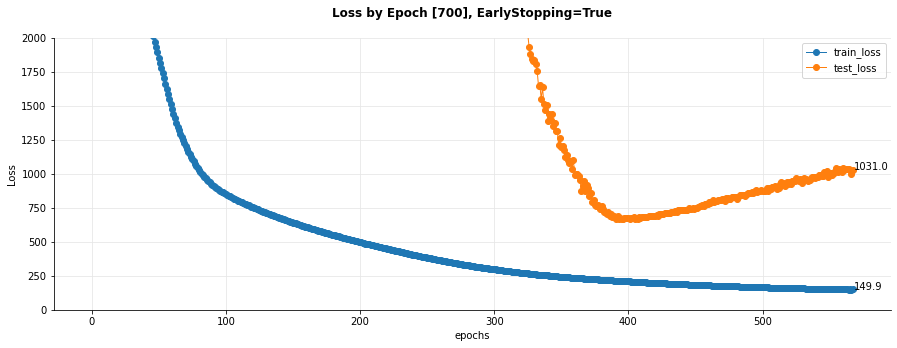

In [19]:
%%time
res = nn_manager_cut.model_fit(n_epoch=700,
                           verbose=0, 
                           return_results=True, 
                           print_charts=True,
                           early_stopping=True
                        );
plt.ylim(0,2e3);

Architectures: <br>
[[#LSTM_Architecture]](#LSTM-based)

Model Compiling setup [[go]](#Compiling-Model-with-the-chosen-Architecture)<br>
Unrolling Seq Len [[go]](#Unrolling-data-to-sequences)<br>

# Saving Model

In [20]:
from datetime import datetime

# nn_manager_cut.model.save(f'./saved_models/{datetime.now().strftime("%Y%m%d_%HH%MM%SS")}_332_Bidi_2d')

In [21]:
# whenloading, pay attention to sequence of days that was used to predict value

# nn_manager_cut.model = keras.models.load_model('./saved_models/20210619_18H21M36S_363_Bidi/')

### Plotting 

In [22]:
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.02.01'"]) 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2020.11.10'", "Date<='2021.04.10'"], legend_loc='upper left') 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2018.06.01'", "Date<='2018.06.15'"]) 

# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date<='2018.03.21'"]) ii

In [23]:
# data_for_pred = nn_manager_cut.scaler.transform(nn_manager_cut.X_test.loc['2018.06.07':'2018.06.09'])
# nn_manager_cut.model_predict(data_for_pred.reshape(1,
#                                                   nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0]


In [24]:
# nn_manager_cut.y_test.loc['2018.06.09']

In [25]:
nn_manager_cut.y_test_unrolled[:3]

array([[7376.8],
       [7372.5],
       [7759.1]])

In [26]:
nn_manager_cut.y_pred[:3]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
nn_manager_cut.y_test[nn_manager_cut.training_seq_params['seq_len']:][:3]

# Conclusion on LSTM Model: